# Preparation

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.transforms import v2
import torchvision.transforms.functional as TF
from torch import nn, optim
from tqdm import tqdm, trange
from torch.utils.data import random_split

from torch.utils.data import Dataset,DataLoader,SubsetRandomSampler
import os
import cv2
import numpy as np
# import lightning as L
# import torchmetrics
# from torchmetrics import Metric
from torch.optim import Adam
# from torchmetrics import JaccardIndex
# from lightning.pytorch.callbacks import EarlyStopping, Callback
import matplotlib.pyplot as plt
import PIL
import random

import cv2

In [ ]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
print(f"Using device: {device}")

device = torch.device(device)


Using device: cuda


In [ ]:
# Hyperparameters
learning_rate = 0.001
batch_size = 16
num_epochs = 20
num_workers=1
data_dir="drive/MyDrive/VOCSegmentationBinaryMask"
min_epochs=1
max_epochs=3
precision=16

In [ ]:
def get_gaussian_kernel(k_gaussian=3, mu=0, sigma=1, normalize=True):
    # create 1D gaussian kernel
    gaussian_1D = np.linspace(-1, 1, k_gaussian)
    # compute probability distribution function
    pdf = np.exp(-0.5 * ((gaussian_1D - mu) / sigma) ** 2)
    # compute 2D kernel
    gaussian_2D = np.outer(pdf, pdf)
    # normalize
    if normalize:
        gaussian_2D /= np.sum(gaussian_2D)
    return gaussian_2D

def get_sobel_kernel(k_sobel=3):
    # get 2D sobel kernel
    sobel_2D = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ]).astype(np.float32)
    return sobel_2D

def get_thin_kernels():
    # kernel for each of the 8 directions
    thin_kernels = [
        # 0 degrees
        np.array([[0, 0, 0], [-1, 1, 0], [0, 0, 0]]),
        # 45 degrees
        np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 0]]),
        # 90 degrees
        np.array([[0, -1, 0], [0, 1, 0], [0, 0, 0]]),
        # 135 degrees
        np.array([[0, 0, -1], [0, 1, 0], [0, 0, 0]]),
        # 180 degrees
        np.array([[0, 0, 0], [0, 1, -1], [0, 0, 0]]),
        # 225 degrees
        np.array([[0, 0, 0], [0, 1, 0], [0, 0, -1]]),
        # 270 degrees
        np.array([[0, 0, 0], [0, 1, 0], [0, -1, 0]]),
        # 315 degrees
        np.array([[0, 0, 0], [0, 1, 0], [-1, 0, 0]])
    ]
    return [k.astype(np.float32) for k in thin_kernels]

In [ ]:


# --- Fixed and Refactored CannyFilter Class ---

class CannyFilter(nn.Module):
    """
    A PyTorch implementation of the Canny Edge Detector.
    This module is designed to be differentiable and can be integrated into a larger
    neural network pipeline.
    """
    def __init__(self, k_gaussian=3, sigma=1, k_sobel=3, device='cpu'):
        super(CannyFilter, self).__init__()
        self.device = device

        # --- Gaussian Filter ---
        gaussian_2D = get_gaussian_kernel(k_gaussian, sigma=sigma)
        # Reshape to (out_channels, in_channels, height, width)
        gaussian_kernel = torch.from_numpy(gaussian_2D).float().unsqueeze(0).unsqueeze(0)

        self.gaussian_filter = nn.Conv2d(in_channels=1,
                                         out_channels=1,
                                         kernel_size=k_gaussian,
                                         padding=k_gaussian // 2,
                                         bias=False)
        self.gaussian_filter.weight = nn.Parameter(gaussian_kernel, requires_grad=False)

        # --- Sobel Filters ---
        sobel_2D_x = get_sobel_kernel(k_sobel)
        sobel_2D_y = sobel_2D_x.T

        sobel_kernel_x = torch.from_numpy(sobel_2D_x).float().unsqueeze(0).unsqueeze(0)
        sobel_kernel_y = torch.from_numpy(sobel_2D_y).float().unsqueeze(0).unsqueeze(0)

        self.sobel_filter_x = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=k_sobel,
                                        padding=k_sobel // 2, bias=False)
        self.sobel_filter_x.weight = nn.Parameter(sobel_kernel_x, requires_grad=False)

        self.sobel_filter_y = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=k_sobel,
                                        padding=k_sobel // 2, bias=False)
        self.sobel_filter_y.weight = nn.Parameter(sobel_kernel_y, requires_grad=False)

        # --- Non-Maximum Suppression (Thinning) Filter ---
        # Instead of looping, we convolve with 8 directional kernels to find neighbors
        thin_kernels = get_thin_kernels()
        directional_kernels = np.stack(thin_kernels)
        # Reshape to (out_channels, in_channels, height, width)
        directional_kernels_torch = torch.from_numpy(directional_kernels).float().unsqueeze(1)

        self.directional_filter = nn.Conv2d(in_channels=1,
                                            out_channels=8,
                                            kernel_size=thin_kernels[0].shape,
                                            padding=thin_kernels[0].shape[-1] // 2,
                                            bias=False)
        self.directional_filter.weight = nn.Parameter(directional_kernels_torch, requires_grad=False)

        # --- Hysteresis ---
        hysteresis_kernel = torch.ones(1, 1, 3, 3)
        self.hysteresis = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias=False)
        self.hysteresis.weight = nn.Parameter(hysteresis_kernel, requires_grad=False)

        # Grayscale conversion weights
        self.rgb_to_gray_weights = torch.tensor([0.299, 0.587, 0.114]).view(1, 3, 1, 1).to(self.device)

        self.to(self.device)

    def forward(self, img, low_threshold=0.1, high_threshold=0.3, hysteresis=True):
        """
        Performs the Canny edge detection algorithm on a batch of images.

        Args:
            img (torch.Tensor): Input image tensor of shape (B, C, H, W).
                                Can be RGB (C=3) or grayscale (C=1).
            low_threshold (float): Lower threshold for edge detection.
            high_threshold (float): Higher threshold for edge detection.
            hysteresis (bool): Whether to apply hysteresis thresholding.

        Returns:
            tuple: A tuple containing intermediate and final results:
                   (blurred, grad_magnitude, thin_edges, final_edges)
        """
        # --- 1. Grayscale Conversion (if necessary) ---
        if img.shape[1] == 3:
            # Apply weighted sum for RGB to grayscale conversion
            gray_img = torch.sum(img * self.rgb_to_gray_weights, dim=1, keepdim=True)
        elif img.shape[1] == 1:
            gray_img = img
        else:
            raise ValueError(f"Input image must have 1 or 3 channels, but got {img.shape[1]}")

        # --- 2. Gaussian Blurring ---
        blurred = self.gaussian_filter(gray_img)

        # --- 3. Sobel Operator for Gradients ---
        grad_x = self.sobel_filter_x(blurred)
        grad_y = self.sobel_filter_y(blurred)

        # --- 4. Gradient Magnitude and Direction ---
        grad_magnitude = torch.hypot(grad_x, grad_y)
        grad_orientation = torch.atan2(grad_y, grad_x) # Use atan2 for quadrant-correct angles

        # Convert radians to degrees [0, 360] and quantize to 8 directions (0, 45, ..., 315)
        grad_orientation_deg = (grad_orientation * 180.0 / np.pi) % 360
        quantized_orientation = torch.round(grad_orientation_deg / 45.0) % 8 # Values from 0 to 7

        # --- 5. Non-Maximum Suppression (Vectorized) ---
        # Get magnitudes of neighbors in the positive and negative gradient directions
        # The directional_filter computes Mag(pixel) - Mag(neighbor) for 8 directions
        # A positive result means the pixel is greater than its neighbor.
        # For NMS, we want Mag(pixel) >= Mag(neighbor1) AND Mag(pixel) >= Mag(neighbor2)
        # The provided `get_thin_kernels` computes `center - neighbor`.
        # To get neighbor values: `center - (center - neighbor)` = `neighbor`
        all_neighbors = grad_magnitude - self.directional_filter(grad_magnitude)

        # Gather neighbors based on quantized orientation
        # `quantized_orientation` has shape (B, 1, H, W), values are indices for dim=1 of `all_neighbors`
        pos_neighbor_idx = quantized_orientation.long()
        neg_neighbor_idx = (quantized_orientation.long() + 4) % 8

        # Use torch.gather to select the correct neighbor magnitude
        pos_neighbors = torch.gather(all_neighbors, dim=1, index=pos_neighbor_idx)
        neg_neighbors = torch.gather(all_neighbors, dim=1, index=neg_neighbor_idx)

        # A pixel is a local maximum if its magnitude is greater than or equal to both its neighbors
        is_local_max = (grad_magnitude >= pos_neighbors) & (grad_magnitude >= neg_neighbors)
        thin_edges = grad_magnitude * is_local_max.float()

        # --- 6. Double Thresholding and Hysteresis ---
        low = low_threshold
        high = high_threshold

        strong_edges = (thin_edges > high).float()
        weak_edges = ((thin_edges >= low) & (thin_edges <= high)).float()

        if hysteresis:
            # Check if weak edges are connected to strong edges
            # A weak edge becomes strong if any of its 8 neighbors is a strong edge
            is_connected = self.hysteresis(strong_edges) > 0
            promoted_weak_edges = weak_edges * is_connected.float()
            final_edges = strong_edges + promoted_weak_edges
        else:
            final_edges = strong_edges + weak_edges

        return blurred, grad_magnitude, thin_edges, final_edges

In [ ]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.
    train_acc = 0.
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images )
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        train_acc += (logits.argmax(1) == labels).type(torch.float).mean().item()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0.
    test_acc = 0.
    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = loss_fn(logits, labels)
            test_loss += loss.item()
            test_acc += (logits.argmax(1) == labels).type(torch.float).mean().item()
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    return test_loss, test_acc

def train_model(model, train_dataloader, test_dataloader, n_epochs, save_path='./drive/MyDrive/model.pth', device=device):
    history = {'train_loss': [],  'test_loss': [], 'train_acc': [], 'test_acc': []}
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    for _ in (pbar := trange(n_epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        pbar.set_description(f'Training Loss {train_loss:.3f} | Training Accuracy {train_acc:.3f} | Test Loss {test_loss:.3f} | Test Accuracy {test_acc:.3f}')
        torch.save(model.state_dict(), save_path)
    return history


def evaluate(model, dataloader, device, n=0):
    model.eval()
    test_loss = 0.
    loss_fn = nn.CrossEntropyLoss()
    with torch.inference_mode():
        for i ,batch in enumerate(dataloader):
            if i != n:
              continue
            images, labels= batch
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = loss_fn(logits, labels)
            test_loss += loss.item()
            break
        test_loss /= len(dataloader)
    return test_loss, images, labels, logits

# Mnist numbers

In [ ]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=v2.Compose([
      v2.ToImage(),
      v2.ToDtype(torch.float32, scale=True),
    ]),
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=v2.Compose([
      v2.ToImage(),
      v2.ToDtype(torch.float32, scale=True),
    ]),
    target_transform=None
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.30MB/s]


In [ ]:
train_data.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layer = nn.Sequential(
        nn.Conv2d(1, 16, 3,stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(16, 32, 3,stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Flatten(),

        nn.Linear(32 * 7 * 7, 32),
        nn.ReLU(),

        nn.Linear(32, 16),
        nn.ReLU(),

        nn.Linear(16, 10),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    logits = self.conv_layer(x)
    return logits

neural_model = NeuralNetwork().to(device)

In [ ]:
res = train_model(neural_model, train_loader, test_loader, 10, './drive/MyDrive/mnist-simple.pth')

Training Loss 0.335 | Training Accuracy 0.894 | Test Loss 0.115 | Test Accuracy 0.961:  10%|█         | 1/10 [00:21<03:16, 21.88s/it]


KeyboardInterrupt: 

In [ ]:
res

{'train_loss': [0.38800771693701047,
  0.10440705956589343,
  0.07375250937618705,
  0.06019621359125804,
  0.04910639702389116,
  0.042589520601662934,
  0.03756481996852347,
  0.032214558891592616,
  0.027292969614124127,
  0.024485167583077352],
 'test_loss': [0.12190914192956083,
  0.07074525642880722,
  0.07337761129903948,
  0.05264365027475913,
  0.04596009068751024,
  0.0514791520781037,
  0.048250001325431176,
  0.04060362068946544,
  0.037089648417453575,
  0.04002917242196648],
 'train_acc': [0.8736507196162047,
  0.9682669243070362,
  0.9772288113006397,
  0.9818596748400853,
  0.9848414179104478,
  0.9870235874200426,
  0.9879231076759062,
  0.9894889392324094,
  0.9916711087420043,
  0.992170842217484],
 'test_acc': [0.9636075949367089,
  0.9791337025316456,
  0.9764636075949367,
  0.9818037974683544,
  0.9853639240506329,
  0.9848694620253164,
  0.9845727848101266,
  0.9856606012658228,
  0.987440664556962,
  0.9859572784810127]}

In [ ]:
class CannyNeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.canny_layer = CannyFilter().to(deivce)
    self.conv_layer = nn.Sequential(
        nn.Conv2d(5, 16, 3,stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(16, 32, 3,stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Flatten(),

        nn.Linear(32 * 7 * 7, 32),
        nn.ReLU(),

        nn.Linear(32, 16),
        nn.ReLU(),

        nn.Linear(16, 10),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    blurred, grad_magnitude, thin_edges, final_edges = self.canny_layer(x)
    x = torch.cat((x, blurred, grad_magnitude, thin_edges, final_edges),dim=1)
    logits = self.conv_layer(x)
    return logits

canny_neural_model = CannyNeuralNetwork().to(device)

NameError: name 'deivce' is not defined

In [ ]:
res = train_model(canny_neural_model, train_loader, test_loader, 10, './drive/MyDrive/mnist-canny.pth')

NameError: name 'canny_neural_model' is not defined

In [ ]:
res

NameError: name 'res' is not defined

# CIFAR10

In [ ]:
train_transform = v2.Compose(
    [
        # v2.RandomHorizontalFlip(),
        # v2.RandomRotation(15),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        # v2.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
    ]
)

test_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        # v2.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
    ]
)


In [ ]:
train_data = datasets.CIFAR10(root="data", train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=test_transform)

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
class CIFAR10Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # Reducing spatial dimensions
        nn.Dropout(0.3),  # Adding dropout to reduce overfitting

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.4),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.5),

        # nn.AdaptiveAvgPool2d(1),

        nn.Flatten(),

        nn.Linear(256* 4* 4, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(1024, 10)
    )

  def forward(self, x):
    return self.layer(x)

In [ ]:
cifar_10_neural = CIFAR10Network().to(device)

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x200704 and 4096x1024)

In [ ]:
cifar_10_neural_res_notaug = train_model(cifar_10_neural, train_loader, test_loader, 10, './drive/MyDrive/cifar_10_neural_res_notaug.pth')

Training Loss 0.572 | Training Accuracy 0.810 | Test Loss 0.522 | Test Accuracy 0.819: 100%|██████████| 10/10 [04:09<00:00, 24.99s/it]


In [ ]:
cifar_10_neural_res_notaug

{'train_loss': [1.7034150878791614,
  1.2108500138725466,
  1.0286372623327749,
  0.914911574033825,
  0.8263557587971773,
  0.7608708605513244,
  0.7039516058648029,
  0.6486245884995936,
  0.609895100755155,
  0.571967765669841],
 'test_loss': [1.2802177426181263,
  0.9870930736577963,
  0.8678352606447437,
  0.7739170163492614,
  0.7359693835053263,
  0.7627305448809757,
  0.641328758454021,
  0.5760793829266029,
  0.6195291842840895,
  0.5223034978667392],
 'train_acc': [0.3773777173913043,
  0.5685541879795396,
  0.6378276854219949,
  0.6816056585677749,
  0.7169317455242967,
  0.7413483056265985,
  0.7629275895140665,
  0.7811500959079284,
  0.7953364769820972,
  0.8099824168797954],
 'test_acc': [0.5325356012658228,
  0.6493275316455697,
  0.6944224683544303,
  0.728935917721519,
  0.7446598101265823,
  0.7491099683544303,
  0.7807555379746836,
  0.805379746835443,
  0.795193829113924,
  0.8193235759493671]}

In [ ]:
cifar_10_neural_res

{'train_loss': [1.6827061738809357,
  1.2973497581603888,
  1.1463475371413219,
  1.0216595400934634,
  0.9318737537049882,
  0.8659439419617738,
  0.8143139726975385,
  0.7728273957739096,
  0.727279611979909,
  0.6920748285549071],
 'test_loss': [1.270028210893462,
  1.1478740799276135,
  0.9948412579826161,
  0.7964691338659842,
  0.7155257139024855,
  0.634435690656493,
  0.6712813969654373,
  0.5901031320608114,
  0.590012589587441,
  0.5430804245834109],
 'train_acc': [0.3843310421994885,
  0.5323089833759591,
  0.5960078324808185,
  0.6418438299232737,
  0.6768102621483376,
  0.7033847506393862,
  0.7210677749360613,
  0.7360933503836317,
  0.7517782928388747,
  0.7665041560102301],
 'test_acc': [0.5238330696202531,
  0.6036392405063291,
  0.6459651898734177,
  0.7263647151898734,
  0.7519778481012658,
  0.7820411392405063,
  0.779568829113924,
  0.7950949367088608,
  0.8010284810126582,
  0.8167523734177216]}

In [ ]:
class CIFAR10Canny(nn.Module):
  def __init__(self):
    super().__init__()
    self.canny_layer = CannyFilter(device=device).to(device)
    self.layer = nn.Sequential(
        nn.Conv2d(7, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # Reducing spatial dimensions
        nn.Dropout(0.3),  # Adding dropout to reduce overfitting

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.4),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.5),

        nn.Flatten(),

        nn.Linear(256* 4* 4, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(1024, 10)
    )

  def forward(self, x):
    blurred, grad_magnitude, thin_edges, final_edges = self.canny_layer(x)
    x = torch.cat((x, blurred, grad_magnitude, thin_edges, final_edges),dim=1)
    return self.layer(x)

In [ ]:
cifar_10_canny = CIFAR10Canny().to(device)

In [ ]:
cifar_10_canny_res_notaug = train_model(cifar_10_canny, train_loader, test_loader, 10, './drive/MyDrive/cifar_10_canny_res_notaug.pth', device)

Training Loss 0.607 | Training Accuracy 0.797 | Test Loss 0.574 | Test Accuracy 0.807: 100%|██████████| 10/10 [04:15<00:00, 25.58s/it]


In [ ]:
cifar_10_canny_res_notaug

{'train_loss': [1.8128118426598552,
  1.3945827442971641,
  1.1943831700650627,
  1.0305254283311116,
  0.9041005424831224,
  0.8194960618339231,
  0.753608421024764,
  0.6915127774867256,
  0.6468959106584949,
  0.6069308175607715],
 'test_loss': [1.5987551604645163,
  1.207650276679027,
  1.076082956941822,
  0.8873466517351851,
  0.7322455901133863,
  0.7284250708320473,
  0.6620679641071754,
  0.6337302440329443,
  0.5766558020929747,
  0.574431981844238],
 'train_acc': [0.33643702046035806,
  0.49268702046035806,
  0.5736093350383632,
  0.6348105818414322,
  0.6861013427109974,
  0.7166320332480819,
  0.7419077685421995,
  0.7649856138107417,
  0.7815497122762148,
  0.7969149616368286],
 'test_acc': [0.4207871835443038,
  0.5677412974683544,
  0.6172863924050633,
  0.6890822784810127,
  0.7439675632911392,
  0.7443631329113924,
  0.7713607594936709,
  0.78125,
  0.803006329113924,
  0.8071598101265823]}

In [ ]:
cifar_10_canny_res

{'train_loss': [1.8369023934044801,
  1.4841378431795809,
  1.3241362640315004,
  1.1907149773576986,
  1.0948742588462732,
  1.0123456689097998,
  0.9457489784111452,
  0.896063527106629,
  0.8468993196020955,
  0.8094791467384914],
 'test_loss': [1.4513258013544204,
  1.3049234574354147,
  1.1256484494933598,
  0.970450434503676,
  0.9060776912713353,
  0.7827551002743878,
  0.7234286967712112,
  0.6702526177786574,
  0.6251164444639713,
  0.5926213204106198],
 'train_acc': [0.3154371803069054,
  0.45656170076726343,
  0.5227181905370843,
  0.5775455562659847,
  0.6193254475703325,
  0.6481777493606138,
  0.6740329283887468,
  0.6930346867007673,
  0.713914641943734,
  0.7264825767263428],
 'test_acc': [0.46054193037974683,
  0.5176028481012658,
  0.5962223101265823,
  0.6561511075949367,
  0.6767207278481012,
  0.7240901898734177,
  0.747626582278481,
  0.7697784810126582,
  0.7878757911392406,
  0.7946004746835443]}

# Food101

In [ ]:
def train_on_single_batch(model, dataloader, n_epochs, device):
    """
    Trains the model on a single batch to check if it can overfit.
    This is a sanity check to ensure the model architecture can learn.
    """
    model.train()

    # --- FIX 1: Optimizer should only target the classifier's parameters ---
    optimizer = Adam(model.classifier.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    # Get a single batch and move it to the correct device
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    print("\n--- Starting single batch overfitting test ---")
    # Loop for n_epochs on the *same* batch
    for _ in (pbar := trange(n_epochs)):
      # Forward pass
      logits = model(images)
      loss = loss_fn(logits, labels)

      # Backward pass and optimization
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      # --- FIX 2 & 3: Corrected loss and accuracy calculation ---
      # loss.item() is already the mean loss for the batch. No need to divide again.
      # .mean().item() on the accuracy check already provides the mean accuracy.
      train_loss = loss.item()
      train_acc = (logits.argmax(1) == labels).type(torch.float).mean().item()

      pbar.set_description(f'Training Loss {train_loss:.4f} | Training Accuracy {train_acc:.4f}')
    print("--- Finished single batch overfitting test ---\n")

In [ ]:

def train_step(model, dataloader, loss_fn, optimizer, device):
    """Performs a single training step on a given dataloader."""
    model.train()
    train_loss = 0.
    train_acc = 0.
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        logits = model(images)
        loss = loss_fn(logits, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        train_loss += loss.item()
        train_acc += (logits.argmax(1) == labels).type(torch.float).mean().item()

    # Calculate average loss and accuracy for the epoch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn, device):
    """Performs a single evaluation step on a given dataloader."""
    model.eval()
    test_loss = 0.
    test_acc = 0.
    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            logits = model(images)
            loss = loss_fn(logits, labels)

            # Accumulate loss and accuracy
            test_loss += loss.item()
            test_acc += (logits.argmax(1) == labels).type(torch.float).mean().item()

        # Calculate average loss and accuracy for the epoch
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    return test_loss, test_acc

def train_model_new(model, train_dataloader, test_dataloader, learning_rate, n_epochs, device, save_path='./food101_model.pth'):
    """
    The main training loop using the train_step and test_step functions.
    """
    history = {'train_loss': [],  'test_loss': [], 'train_acc': [], 'test_acc': []}

    # --- CRITICAL FIX ---
    # The optimizer MUST only be passed the parameters of the part of the model
    # that we want to train. In this case, it's just the classifier.
    optimizer = Adam(model.classifier.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    print("\n--- Starting New Training Loop ---")
    for epoch in (pbar := trange(n_epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        pbar.set_description(f'Epoch {epoch+1} | Train Loss {train_loss:.3f} | Train Acc {train_acc:.3f} | Test Loss {test_loss:.3f} | Test Acc {test_acc:.3f}')

    # Save the model after the final epoch
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")
    return history


In [ ]:
train_transform = v2.Compose(
    [
        v2.Resize(size=(224, 224)),
        v2.RandomHorizontalFlip(),
        v2.RandomRotation((0, 15)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Standard ImageNet normalization
    ]
)

# Validation & Test Transform (No Augmentation)
test_transform = v2.Compose(
    [
        v2.Resize(size=(224, 224)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


In [ ]:
train_data = datasets.Food101(
    root="data",
    split='train',
    download=True,
    transform=train_transform,
    target_transform=None
)

test_data = datasets.Food101(
    root="data",
    split='test',
    download=True,
    transform=test_transform,
    target_transform=None
)

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
len(train_data.classes)

101

(<matplotlib.image.AxesImage at 0x780ee5a2a1d0>, tensor(9))

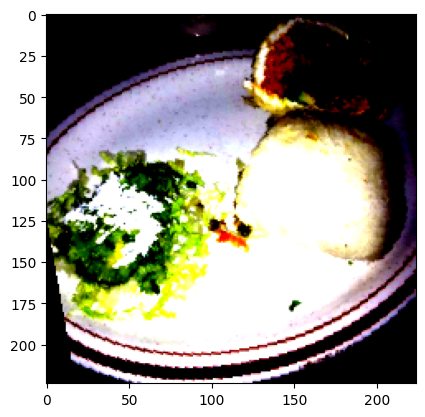

In [ ]:
images, labels = next(iter(train_loader))
plt.imshow(images[0].permute(1,2,0)), labels[0]

In [ ]:

class Food101NeuralNetwork(nn.Module):
  """
  A neural network for classifying the Food101 dataset using a pre-trained
  AlexNet model as a feature extractor.
  """
  def __init__(self, num_classes=101):
    """
    Initializes the model.
    Args:
      num_classes (int): The number of output classes (101 for Food101).
    """
    super().__init__()
    # Use a pre-trained AlexNet model as a base
    # Using the recommended modern weights API
    alexnet_base = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    # --- Feature Extractor (Convolutional Layers) ---
    self.features = alexnet_base.features

    # --- FREEZE THE PRE-TRAINED LAYERS ---
    # This is a critical step for transfer learning. We don't want to
    # destroy the learned features from ImageNet by backpropagating through them
    # with random weights from our new classifier.
    for param in self.features.parameters():
        param.requires_grad = False

    # --- New Classifier ---
    # We replace AlexNet's original classifier with our own.
    # The input features to the classifier are 256 * 6 * 6, which is the
    # output shape from the AlexNet feature extractor for a 224x224 image.
    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes) # Output layer for 101 classes
    )

  def forward(self, x):
    """
    Defines the forward pass of the model.
    """
    # Pass input through the feature extractor
    x = self.features(x)
    # Flatten the feature map for the classifier
    # The view operation reshapes the tensor. x.size(0) is the batch size.
    # -1 infers the remaining dimensions, creating a flat vector.
    x = x.view(x.size(0), -1)
    # Pass the flattened features through the classifier
    x = self.classifier(x)
    return x


In [ ]:
# prompt: now make it to accept 3 chanels and output 101 classes

class Food101NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    # Use a pre-trained AlexNet model as a base
    self.features = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1).features
    # Modify the classifier for 101 classes
    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, 101) # Output layer for 101 classes
    )

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x.view(x.size(0), -1)) # Flatten for the classifier
    return x


# Train only the classifier initially
# Unfreeze after a few epochs if desired for fine-tuning

# Example of unfreezing for fine-tuning (optional)
# for param in food101_model.features.parameters():
#     param.requires_grad = True

# res_food101_finetune = train_model(food101_model, train_loader, test_loader, 5, './drive/MyDrive/food101_alexnet_finetune.pth', device)
# print(res_food101_finetune)


In [ ]:
food101_model = Food101NeuralNetwork().to(device)

# Freeze the feature layers initially
# for param in food101_model.features.parameters():
#     param.requires_grad = False


In [ ]:
train_on_single_batch(food101_model, train_loader, n_epochs=1000, device=device)


--- Starting single batch overfitting test ---


Training Loss 0.0000 | Training Accuracy 1.0000: 100%|██████████| 1000/1000 [00:39<00:00, 25.11it/s]

--- Finished single batch overfitting test ---



In [ ]:
# model, train_dataloader, test_dataloader, learning_rate, n_epochs, device, save_path='./food101_model.pth'
res_food101 = train_model_new(food101_model, train_loader, test_loader,learning_rate, 5,device, './drive/MyDrive/food101_alexnet.pth', )
res_food101


--- Starting New Training Loop ---


Epoch 5 | Train Loss 4.165 | Train Acc 0.056 | Test Loss 3.930 | Test Acc 0.120: 100%|██████████| 5/5 [57:48<00:00, 693.63s/it]


Model saved to ./drive/MyDrive/food101_alexnet.pth


{'train_loss': [4.430714592639659,
  4.286177836861965,
  4.237399053331968,
  4.190981372788146,
  4.165055306678688],
 'test_loss': [4.119403818641046,
  4.032989445358816,
  3.9790178573492803,
  3.904550051448321,
  3.9304611977904735],
 'train_acc': [0.03201541385135135,
  0.04063291807432432,
  0.04609638935810811,
  0.05224609375,
  0.05631510416876424],
 'test_acc': [0.06407828282828283,
  0.09437202911522954,
  0.11193274661447063,
  0.12352384137685853,
  0.11963383838383838]}

In [ ]:
class Food101Canny(nn.Module):
  """
  A neural network for classifying the Food101 dataset using a pre-trained
  AlexNet model as a feature extractor. This version is modified to accept
  a custom number of input channels (e.g., 7).
  """
  def __init__(self, num_classes=101, in_channels=7):
    """
    Initializes the model.
    Args:
      num_classes (int): The number of output classes (101 for Food101).
      in_channels (int): The number of input channels for the images.
    """
    super().__init__()
    # Use a pre-trained AlexNet model as a base
    alexnet_base = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    # --- MODIFICATION FOR 7-CHANNEL INPUT ---
    # The original AlexNet model is trained on 3-channel (RGB) images.
    # We need to replace its first convolutional layer to handle 7 channels.

    # 1. Get the original first convolutional layer and its weights
    original_first_layer = alexnet_base.features[0]
    original_weights = original_first_layer.weight

    # 2. Create a new convolutional layer with the desired number of input channels
    new_first_layer = nn.Conv2d(
        in_channels=in_channels,
        out_channels=original_first_layer.out_channels,
        kernel_size=original_first_layer.kernel_size,
        stride=original_first_layer.stride,
        padding=original_first_layer.padding,
        bias=(original_first_layer.bias is not None)
    )

    # 3. Adapt the pre-trained weights for the new layer
    with torch.no_grad():
        # Calculate the mean of the weights from the original 3 RGB channels
        mean_weights = original_weights.mean(dim=1, keepdim=True)

        # Expand the mean weights to match the number of new channels (7 - 3 = 4)
        # This provides a reasonable starting point for the new channels' weights
        expanded_mean_weights = mean_weights.expand(-1, in_channels - 3, -1, -1)

        # Concatenate the original RGB weights with the new initialized weights
        new_weights = torch.cat([original_weights, expanded_mean_weights], dim=1)

        # Assign the adapted weights and original bias to our new layer
        new_first_layer.weight.data = new_weights
        if original_first_layer.bias is not None:
            new_first_layer.bias.data = original_first_layer.bias.data

    # 4. Replace the original first layer with our new 7-channel layer
    alexnet_base.features[0] = new_first_layer
    # --- END OF MODIFICATION ---

    self.canny_layer = CannyFilter(device=device).to(device)
    self.features = alexnet_base.features

    # Freeze all the pre-trained layers
    for param in self.features.parameters():
        param.requires_grad = False

    # IMPORTANT: Un-freeze our new first layer so its weights can be trained
    for param in self.features[0].parameters():
        param.requires_grad = True

    # The classifier part remains the same
    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes)
    )

  def forward(self, x):
    """
    Defines the forward pass of the model.
    """
    blurred, grad_magnitude, thin_edges, final_edges = self.canny_layer(x)
    x = torch.cat((x, blurred, grad_magnitude, thin_edges, final_edges),dim=1)
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x


In [ ]:
food101_canny_model = Food101Canny().to(device)

In [ ]:
food101_canny_model_res = train_model(food101_canny_model, train_loader, test_loader, 5, './drive/MyDrive/food101_canny_model.pth')

Training Loss 4.569 | Training Accuracy 0.017 | Test Loss 4.522 | Test Accuracy 0.023:  60%|██████    | 3/5 [36:04<24:04, 722.41s/it]

In [ ]:
food101_canny_model_res

# Random

In [ ]:
# Hyperparameters
learning_rate = 0.001
batch_size = 16
num_epochs = 20
num_workers=1
data_dir="drive/MyDrive/VOCSegmentationBinaryMask"
min_epochs=1
max_epochs=3
precision=16

In [ ]:

image_transforms = v2.Compose([
    v2.Resize((256, 256)), # Resize images to a common size for model input
    v2.ToImage(),          # Convert PIL Image to PyTorch Image Tensor
    v2.ToDtype(torch.float32, scale=True), # Convert to float32 and scale to [0, 1]
    # Normalize with ImageNet stats. Adjust if your pre-trained model uses different stats.
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transforms = v2.Compose([
    v2.Resize((256, 256), interpolation=v2.InterpolationMode.NEAREST),
    v2.ToImage(),          # Convert PIL Image to PyTorch Image Tensor
    v2.ToDtype(torch.float32, scale=True) # Convert to float32 and scale to [0, 1]
])


In [ ]:
dataset = datasets.VOCSegmentation(
            root=data_dir,
            image_set="train",
            download=False,
            transform=image_transforms,
            target_transform=target_transforms
  )

In [ ]:
data_loader = DataLoader(dataset, batch_size=4, shuffle=False)

In [ ]:
images, masks = next(iter(data_loader))

In [ ]:
def get_gaussian_kernel(k=3, mu=0, sigma=1, normalize=True):
    # compute 1 dimension gaussian
    gaussian_1D = np.linspace(-1, 1, k)
    # compute a grid distance from center
    x, y = np.meshgrid(gaussian_1D, gaussian_1D)
    distance = (x ** 2 + y ** 2) ** 0.5

    # compute the 2 dimension gaussian
    gaussian_2D = np.exp(-(distance - mu) ** 2 / (2 * sigma ** 2))
    gaussian_2D = gaussian_2D / (2 * np.pi *sigma **2)

    # normalize part (mathematically)
    if normalize:
        gaussian_2D = gaussian_2D / np.sum(gaussian_2D)
    return gaussian_2D

In [ ]:
def get_sobel_kernel(k=3):
    # get range
    range = np.linspace(-(k // 2), k // 2, k)
    # compute a grid the numerator and the axis-distances
    x, y = np.meshgrid(range, range)
    sobel_2D_numerator = x
    sobel_2D_denominator = (x ** 2 + y ** 2)
    sobel_2D_denominator[:, k // 2] = 1  # avoid division by zero
    sobel_2D = sobel_2D_numerator / sobel_2D_denominator
    return sobel_2D

In [ ]:
def get_thin_kernels(start=0, end=360, step=45):
        k_thin = 3  # actual size of the directional kernel
        # increase for a while to avoid interpolation when rotating
        k_increased = k_thin + 2

        # get 0° angle directional kernel
        thin_kernel_0 = np.zeros((k_increased, k_increased))
        thin_kernel_0[k_increased // 2, k_increased // 2] = 1
        thin_kernel_0[k_increased // 2, k_increased // 2 + 1:] = -1

        # rotate the 0° angle directional kernel to get the other ones
        thin_kernels = []
        for angle in range(start, end, step):
            (h, w) = thin_kernel_0.shape
            # get the center to not rotate around the (0, 0) coord point
            center = (w // 2, h // 2)
            # apply rotation
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
            kernel_angle_increased = cv2.warpAffine(thin_kernel_0, rotation_matrix, (w, h), cv2.INTER_NEAREST)

            # get the k=3 kerne
            kernel_angle = kernel_angle_increased[1:-1, 1:-1]
            is_diag = (abs(kernel_angle) == 1)      # because of the interpolation
            kernel_angle = kernel_angle * is_diag   # because of the interpolation
            thin_kernels.append(kernel_angle)
        return thin_kernels

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# --- Helper functions (assumed to be defined elsewhere, provided here for completeness) ---

def get_gaussian_kernel(k_gaussian=3, mu=0, sigma=1, normalize=True):
    # create 1D gaussian kernel
    gaussian_1D = np.linspace(-1, 1, k_gaussian)
    # compute probability distribution function
    pdf = np.exp(-0.5 * ((gaussian_1D - mu) / sigma) ** 2)
    # compute 2D kernel
    gaussian_2D = np.outer(pdf, pdf)
    # normalize
    if normalize:
        gaussian_2D /= np.sum(gaussian_2D)
    return gaussian_2D

def get_sobel_kernel(k_sobel=3):
    # get 2D sobel kernel
    sobel_2D = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ]).astype(np.float32)
    return sobel_2D

def get_thin_kernels():
    # kernel for each of the 8 directions
    thin_kernels = [
        # 0 degrees
        np.array([[0, 0, 0], [-1, 1, 0], [0, 0, 0]]),
        # 45 degrees
        np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 0]]),
        # 90 degrees
        np.array([[0, -1, 0], [0, 1, 0], [0, 0, 0]]),
        # 135 degrees
        np.array([[0, 0, -1], [0, 1, 0], [0, 0, 0]]),
        # 180 degrees
        np.array([[0, 0, 0], [0, 1, -1], [0, 0, 0]]),
        # 225 degrees
        np.array([[0, 0, 0], [0, 1, 0], [0, 0, -1]]),
        # 270 degrees
        np.array([[0, 0, 0], [0, 1, 0], [0, -1, 0]]),
        # 315 degrees
        np.array([[0, 0, 0], [0, 1, 0], [-1, 0, 0]])
    ]
    return [k.astype(np.float32) for k in thin_kernels]

# --- Fixed and Refactored CannyFilter Class ---

class CannyFilter(nn.Module):
    """
    A PyTorch implementation of the Canny Edge Detector.
    This module is designed to be differentiable and can be integrated into a larger
    neural network pipeline.
    """
    def __init__(self, k_gaussian=3, sigma=1, k_sobel=3, device='cpu'):
        super(CannyFilter, self).__init__()
        self.device = device

        # --- Gaussian Filter ---
        gaussian_2D = get_gaussian_kernel(k_gaussian, sigma=sigma)
        # Reshape to (out_channels, in_channels, height, width)
        gaussian_kernel = torch.from_numpy(gaussian_2D).float().unsqueeze(0).unsqueeze(0)

        self.gaussian_filter = nn.Conv2d(in_channels=1,
                                         out_channels=1,
                                         kernel_size=k_gaussian,
                                         padding=k_gaussian // 2,
                                         bias=False)
        self.gaussian_filter.weight = nn.Parameter(gaussian_kernel, requires_grad=False)

        # --- Sobel Filters ---
        sobel_2D_x = get_sobel_kernel(k_sobel)
        sobel_2D_y = sobel_2D_x.T

        sobel_kernel_x = torch.from_numpy(sobel_2D_x).float().unsqueeze(0).unsqueeze(0)
        sobel_kernel_y = torch.from_numpy(sobel_2D_y).float().unsqueeze(0).unsqueeze(0)

        self.sobel_filter_x = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=k_sobel,
                                        padding=k_sobel // 2, bias=False)
        self.sobel_filter_x.weight = nn.Parameter(sobel_kernel_x, requires_grad=False)

        self.sobel_filter_y = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=k_sobel,
                                        padding=k_sobel // 2, bias=False)
        self.sobel_filter_y.weight = nn.Parameter(sobel_kernel_y, requires_grad=False)

        # --- Non-Maximum Suppression (Thinning) Filter ---
        # Instead of looping, we convolve with 8 directional kernels to find neighbors
        thin_kernels = get_thin_kernels()
        directional_kernels = np.stack(thin_kernels)
        # Reshape to (out_channels, in_channels, height, width)
        directional_kernels_torch = torch.from_numpy(directional_kernels).float().unsqueeze(1)

        self.directional_filter = nn.Conv2d(in_channels=1,
                                            out_channels=8,
                                            kernel_size=thin_kernels[0].shape,
                                            padding=thin_kernels[0].shape[-1] // 2,
                                            bias=False)
        self.directional_filter.weight = nn.Parameter(directional_kernels_torch, requires_grad=False)

        # --- Hysteresis ---
        hysteresis_kernel = torch.ones(1, 1, 3, 3)
        self.hysteresis = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias=False)
        self.hysteresis.weight = nn.Parameter(hysteresis_kernel, requires_grad=False)

        # Grayscale conversion weights
        self.rgb_to_gray_weights = torch.tensor([0.299, 0.587, 0.114]).view(1, 3, 1, 1).to(self.device)

        self.to(self.device)

    def forward(self, img, low_threshold=0.1, high_threshold=0.3, hysteresis=True):
        """
        Performs the Canny edge detection algorithm on a batch of images.

        Args:
            img (torch.Tensor): Input image tensor of shape (B, C, H, W).
                                Can be RGB (C=3) or grayscale (C=1).
            low_threshold (float): Lower threshold for edge detection.
            high_threshold (float): Higher threshold for edge detection.
            hysteresis (bool): Whether to apply hysteresis thresholding.

        Returns:
            tuple: A tuple containing intermediate and final results:
                   (blurred, grad_magnitude, thin_edges, final_edges)
        """
        # --- 1. Grayscale Conversion (if necessary) ---
        if img.shape[1] == 3:
            # Apply weighted sum for RGB to grayscale conversion
            gray_img = torch.sum(img * self.rgb_to_gray_weights, dim=1, keepdim=True)
        elif img.shape[1] == 1:
            gray_img = img
        else:
            raise ValueError(f"Input image must have 1 or 3 channels, but got {img.shape[1]}")

        # --- 2. Gaussian Blurring ---
        blurred = self.gaussian_filter(gray_img)

        # --- 3. Sobel Operator for Gradients ---
        grad_x = self.sobel_filter_x(blurred)
        grad_y = self.sobel_filter_y(blurred)

        # --- 4. Gradient Magnitude and Direction ---
        grad_magnitude = torch.hypot(grad_x, grad_y)
        grad_orientation = torch.atan2(grad_y, grad_x) # Use atan2 for quadrant-correct angles

        # Convert radians to degrees [0, 360] and quantize to 8 directions (0, 45, ..., 315)
        grad_orientation_deg = (grad_orientation * 180.0 / np.pi) % 360
        quantized_orientation = torch.round(grad_orientation_deg / 45.0) % 8 # Values from 0 to 7

        # --- 5. Non-Maximum Suppression (Vectorized) ---
        # Get magnitudes of neighbors in the positive and negative gradient directions
        # The directional_filter computes Mag(pixel) - Mag(neighbor) for 8 directions
        # A positive result means the pixel is greater than its neighbor.
        # For NMS, we want Mag(pixel) >= Mag(neighbor1) AND Mag(pixel) >= Mag(neighbor2)
        # The provided `get_thin_kernels` computes `center - neighbor`.
        # To get neighbor values: `center - (center - neighbor)` = `neighbor`
        all_neighbors = grad_magnitude - self.directional_filter(grad_magnitude)

        # Gather neighbors based on quantized orientation
        # `quantized_orientation` has shape (B, 1, H, W), values are indices for dim=1 of `all_neighbors`
        pos_neighbor_idx = quantized_orientation.long()
        neg_neighbor_idx = (quantized_orientation.long() + 4) % 8

        # Use torch.gather to select the correct neighbor magnitude
        pos_neighbors = torch.gather(all_neighbors, dim=1, index=pos_neighbor_idx)
        neg_neighbors = torch.gather(all_neighbors, dim=1, index=neg_neighbor_idx)

        # A pixel is a local maximum if its magnitude is greater than or equal to both its neighbors
        is_local_max = (grad_magnitude >= pos_neighbors) & (grad_magnitude >= neg_neighbors)
        thin_edges = grad_magnitude * is_local_max.float()

        # --- 6. Double Thresholding and Hysteresis ---
        low = low_threshold
        high = high_threshold

        strong_edges = (thin_edges > high).float()
        weak_edges = ((thin_edges >= low) & (thin_edges <= high)).float()

        if hysteresis:
            # Check if weak edges are connected to strong edges
            # A weak edge becomes strong if any of its 8 neighbors is a strong edge
            is_connected = self.hysteresis(strong_edges) > 0
            promoted_weak_edges = weak_edges * is_connected.float()
            final_edges = strong_edges + promoted_weak_edges
        else:
            final_edges = strong_edges + weak_edges

        return blurred, grad_magnitude, thin_edges, final_edges

In [ ]:
canny = CannyFilter()
canny.eval()

CannyFilter(
  (gaussian_filter): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sobel_filter_x): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sobel_filter_y): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (directional_filter): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (hysteresis): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

In [ ]:
blurred, grad_magnitude, thin_edges, final_edges = canny(images)

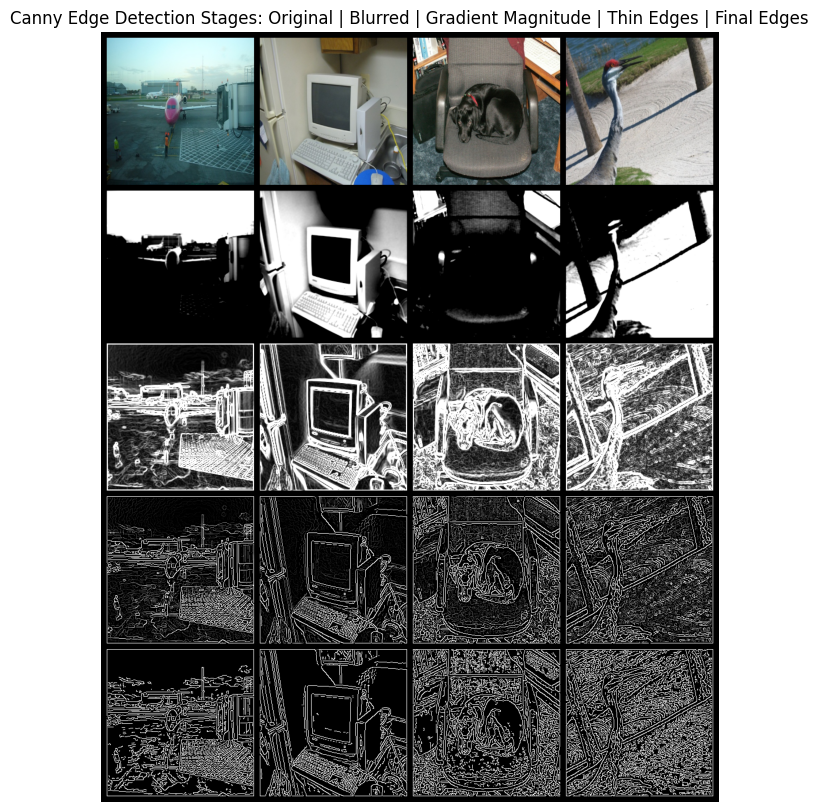

In [ ]:
# prompt: using pytorch grid, plot blurred, grad_magnitude, thin_edges, final_edges

import matplotlib.pyplot as plt
import torchvision
def denormalize(images, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize image batch."""
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(images.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(images.device)
    return images * std + mean

# Denormalize the original images for comparison if needed
denormalized_images = denormalize(images.cpu())

# Ensure tensors are on CPU for plotting
blurred_cpu = blurred.detach().cpu()
grad_magnitude_cpu = grad_magnitude.detach().cpu()
thin_edges_cpu = thin_edges.detach().cpu()
final_edges_cpu = final_edges.detach().cpu()

# Clamp edge outputs to be between 0 and 1 for proper visualization
grad_magnitude_cpu = torch.clamp(grad_magnitude_cpu, 0, 1)
thin_edges_cpu = torch.clamp(thin_edges_cpu, 0, 1)
final_edges_cpu = torch.clamp(final_edges_cpu, 0, 1)


# Since Canny operates on grayscale, the outputs are 1 channel.
# We need to make them 3 channels to use torchvision.utils.make_grid
# For grayscale outputs, we can replicate the channel to visualize them
# as grayscale images (where R=G=B=pixel_value).
blurred_rgb = blurred_cpu.repeat(1, 3, 1, 1)
grad_magnitude_rgb = grad_magnitude_cpu.repeat(1, 3, 1, 1)
thin_edges_rgb = thin_edges_cpu.repeat(1, 3, 1, 1)
final_edges_rgb = final_edges_cpu.repeat(1, 3, 1, 1)


# Concatenate images and outputs vertically
# Each row will correspond to one image in the batch
# Each column will be the original image, blurred, grad_magnitude, thin_edges, final_edges
combined_images = torch.cat((
    denormalized_images, # Original images
    blurred_rgb,
    grad_magnitude_rgb,
    thin_edges_rgb,
    final_edges_rgb
), dim=0) # Stack along batch dimension

# Make a grid of the combined images
# The `nrow` parameter determines how many images appear in a row.
# We want each image from the batch to be a row, and each column to be a different stage
# So, for a batch size of B, we will have B rows and 5 columns (Original, Blurred, Mag, Thin, Final)
grid = torchvision.utils.make_grid(combined_images, nrow=4, padding=10)

# Transpose the grid dimensions to get the desired layout (images as rows)
# The make_grid function returns a tensor of shape (C, H_grid, W_grid)
# We want it in (H_grid, W_grid, C) for matplotlib
grid = grid.permute(1, 2, 0)

# Plot the grid
plt.figure(figsize=(20, 10))
plt.imshow(grid)
plt.axis('off')
plt.title('Canny Edge Detection Stages: Original | Blurred | Gradient Magnitude | Thin Edges | Final Edges')
plt.show()

In [ ]:
layer = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1)

In [ ]:
images.shape, blurred.shape, grad_magnitude.shape, thin_edges.shape, final_edges.shape

(torch.Size([4, 3, 256, 256]),
 torch.Size([4, 1, 256, 256]),
 torch.Size([4, 1, 256, 256]),
 torch.Size([4, 1, 256, 256]),
 torch.Size([4, 1, 256, 256]))

In [ ]:
# Make sure all tensors are on the CPU and are float32
blurred_cpu = blurred.detach().cpu().float()
grad_magnitude_cpu = grad_magnitude.detach().cpu().float()
thin_edges_cpu = thin_edges.detach().cpu().float()
final_edges_cpu = final_edges.detach().cpu().float()

# Clamp outputs to [0, 1] for consistent scaling if not already done by the filter
blurred_cpu = torch.clamp(blurred_cpu, 0, 1)
grad_magnitude_cpu = torch.clamp(grad_magnitude_cpu, 0, 1)
thin_edges_cpu = torch.clamp(thin_edges_cpu, 0, 1)
final_edges_cpu = torch.clamp(final_edges_cpu, 0, 1)


batch_size_target = images.shape[0]

images_batch = images[:batch_size_target].detach().cpu()
blurred_batch = blurred[:batch_size_target].detach().cpu()
grad_magnitude_batch = grad_magnitude[:batch_size_target].detach().cpu()
thin_edges_batch = thin_edges[:batch_size_target].detach().cpu()
final_edges_batch = final_edges[:batch_size_target].detach().cpu()


# Clamp and convert to float32 if not already
blurred_batch = torch.clamp(blurred_batch.float(), 0, 1)
grad_magnitude_batch = torch.clamp(grad_magnitude_batch.float(), 0, 1)
thin_edges_batch = torch.clamp(thin_edges_batch.float(), 0, 1)
final_edges_batch = torch.clamp(final_edges_batch.float(), 0, 1)


# Stack the outputs along the channel dimension
# This results in a tensor of shape (4, 4, 256, 256), where the 4 channels are:
# [blurred, grad_magnitude, thin_edges, final_edges]
stacked_outputs = torch.cat((
    blurred_batch,
    grad_magnitude_batch,
    thin_edges_batch,
    final_edges_batch
), dim=1)

denormalized_images_batch = denormalize(images_batch)

# Concatenate original 3 channels with the 4 Canny output channels
# This will create a tensor of shape (4, 3 + 4, 256, 256) = (4, 7, 256, 256)
final_stacked_tensor = torch.cat((
    denormalized_images_batch, # Shape (4, 3, 256, 256)
    blurred_batch,             # Shape (4, 1, 256, 256)
    grad_magnitude_batch,      # Shape (4, 1, 256, 256)
    thin_edges_batch,          # Shape (4, 1, 256, 256)
    final_edges_batch          # Shape (4, 1, 256, 256)
), dim=1)

print(f"Shape of the stacked tensor: {final_stacked_tensor.shape}")


Shape of the stacked tensor: torch.Size([4, 7, 256, 256])


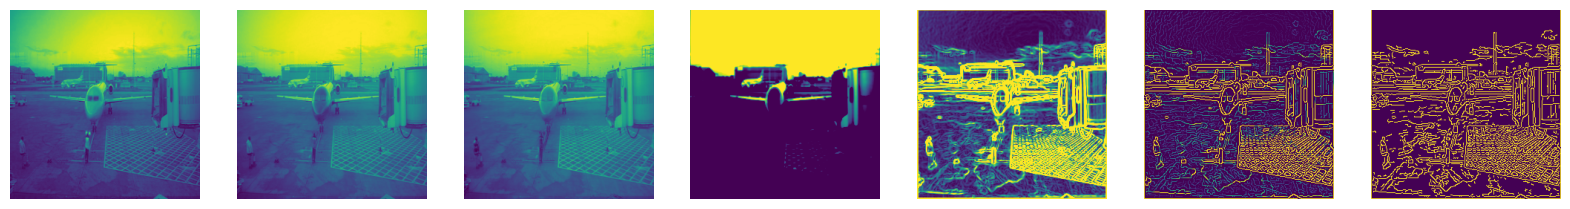

In [ ]:
set_one = final_stacked_tensor[0]

plt.figure(figsize=(20, 10))

plt.subplot(1,7,1)
plt.imshow(set_one[0])
plt.axis('off')

plt.subplot(1,7,2)
plt.imshow(set_one[1])
plt.axis('off')

plt.subplot(1,7,3)
plt.imshow(set_one[2])
plt.axis('off')

plt.subplot(1,7,4)
plt.imshow(set_one[3])
plt.axis('off')

plt.subplot(1,7,5)
plt.imshow(set_one[4])
plt.axis('off')

plt.subplot(1,7,6)
plt.imshow(set_one[5])
plt.axis('off')

plt.subplot(1,7,7)
plt.imshow(set_one[6])
plt.axis('off')

plt.show()